In [1]:
import argparse
import os
import copy
import tqdm

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert, box_iou

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt

from huggingface_hub import hf_hub_download

import open3d as o3d
import numpy as np
import os
import k3d
import glob

/scratch/rhm4nj/cral/.venv/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device, weights_only=True)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

device = "cuda:0"
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

final text_encoder_type: bert-base-uncased
Model loaded from /home/rhm4nj/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [3]:
sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint))

In [4]:
from torchvision.ops import box_iou

TEXT_PROMPTS  = [
    "furniture",
    "electronics",
    "appliances",
    "textiles",
    "decor",
    "lighting",
    "tools",
    "toys",
    "utensils",
    "storage",
    "plumbing",
    "plants",
    "kitchenware",
    "bedding",
    "clothing"
]
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25
overlap_threshold = 0.8

color_path = "/scratch/rhm4nj/cral/datasets/SUNRGBD/realsense/sh/2014_10_21-11_33_55-1311000041/image/0000075.jpg"
image_source, image = load_image(color_path)
# image_source = cv2.imread(color_path)
# image_source = cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB)

all_boxes = torch.tensor([])
all_logits = torch.tensor([])
all_phrases = []

for TEXT_PROMPT in TEXT_PROMPTS:
    boxes, logits, phrases = predict(
        model=groundingdino_model,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    all_boxes = torch.concat([all_boxes, boxes])
    all_logits = torch.concat([all_logits, logits])
    all_phrases.extend(phrases)

iou_matrix = box_iou(all_boxes, all_boxes)
keep_indices = []
for i in range(len(all_boxes)):
    if all(iou_matrix[i, j] <= overlap_threshold for j in keep_indices):
        keep_indices.append(i)

all_boxes = all_boxes[keep_indices]
all_logits = all_logits[keep_indices]
all_phrases = [all_phrases[i] for i in keep_indices]

annotated_frame = annotate(image_source=image_source, boxes=all_boxes, logits=all_logits, phrases=all_phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

print(all_boxes)

tensor([[0.2683, 0.3451, 0.4274, 0.3857],
        [0.1125, 0.4386, 0.2242, 0.3399],
        [0.8070, 0.6223, 0.3857, 0.7498],
        [0.2742, 0.1255, 0.1097, 0.1508],
        [0.2741, 0.1255, 0.1105, 0.1517],
        [0.8530, 0.3594, 0.1796, 0.1708],
        [0.5258, 0.4198, 0.2093, 0.3334],
        [0.2741, 0.1256, 0.1088, 0.1505],
        [0.0564, 0.6061, 0.1113, 0.1545],
        [0.5989, 0.5901, 0.3540, 0.6691],
        [0.5260, 0.4171, 0.2123, 0.3321]])


[  0.       39.88658 386.45605 326.63745]
[  0.      106.52238 183.50139 359.231  ]
[365.70593   51.724426 680.       530.      ]
[134.4565    10.595932 239.04399  122.69661 ]
[133.98248   10.223839 239.2945   123.010994]
[495.24976  127.357254 666.5117   254.3289  ]
[258.31918   98.985855 457.82138  346.8637  ]
[134.79916   10.724049 238.54056  122.63078 ]
[  0.      264.43848  91.4637  379.28088]
[239.08833  64.60365 576.6259  530.     ]
[257.0105   98.04462 459.40192 344.93433]


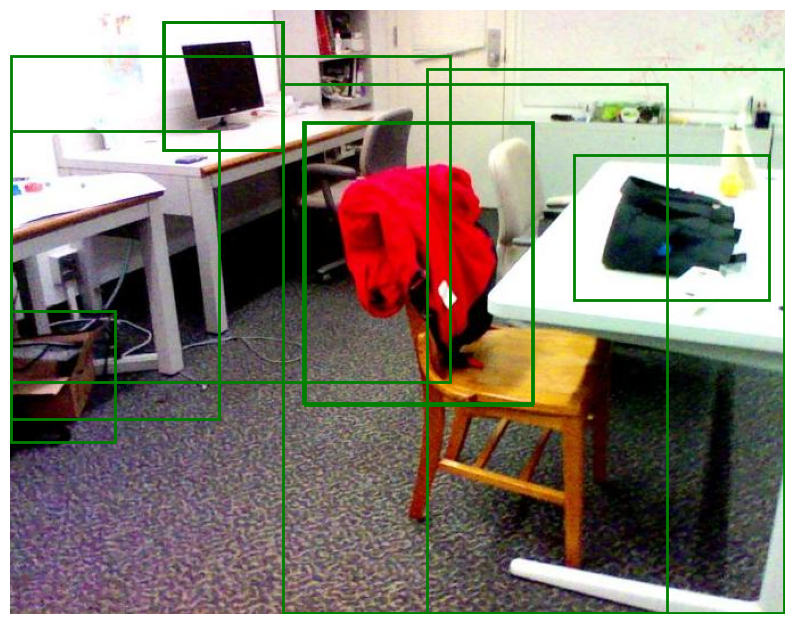

In [5]:
# image = cv2.imread(color_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

H, W, _ = image_source.shape
boxes_xyxy_og = box_ops.box_cxcywh_to_xyxy(all_boxes) * torch.Tensor([W, H, W, H])

increase_factor = 0.4

# Calculate widths and heights
widths = boxes_xyxy_og[:, 2] - boxes_xyxy_og[:, 0]
heights = boxes_xyxy_og[:, 3] - boxes_xyxy_og[:, 1]

new_widths = widths * (1 + increase_factor)
new_heights = heights * (1 + increase_factor)

center_x = boxes_xyxy_og[:, 0] + widths / 2
center_y = boxes_xyxy_og[:, 1] + heights / 2
centers = torch.vstack([center_x, center_y]).T

boxes_xyxy = torch.zeros_like(boxes_xyxy_og)
boxes_xyxy[:, 0] = center_x - new_widths / 2  # x_min
boxes_xyxy[:, 1] = center_y - new_heights / 2  # y_min
boxes_xyxy[:, 2] = center_x + new_widths / 2  # x_max
boxes_xyxy[:, 3] = center_y + new_heights / 2  # y_max

boxes_xyxy[:, 0] = torch.clamp(boxes_xyxy[:, 0], min=0)  # x_min >= 0
boxes_xyxy[:, 1] = torch.clamp(boxes_xyxy[:, 1], min=0)  # y_min >= 0
boxes_xyxy[:, 2] = torch.clamp(boxes_xyxy[:, 2], max=W-1)  # x_max <= image_width
boxes_xyxy[:, 3] = torch.clamp(boxes_xyxy[:, 3], max=H-1)  # y_max <= image_height

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

image_cv = cv2.imread(color_path)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image_source)
for box in boxes_xyxy:
    show_box(box.cpu().numpy(), plt.gca())
    print(box.cpu().numpy())
# for input_point in centers:
#     show_points(input_point.unsqueeze(0), torch.tensor([1]), plt.gca())
#     print(input_point)

plt.axis('off')
plt.show()


In [6]:
# image = cv2.imread(color_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

sam_predictor.set_image(image_source)
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image.shape[:2])

masks, scores, logits = sam_predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

print(transformed_boxes.shape)
print(masks.shape)

torch.Size([11, 4])
torch.Size([11, 1, 531, 681])


[  0.       39.88658 386.45605 326.63745]
[  0.      106.52238 183.50139 359.231  ]
[365.70593   51.724426 680.       530.      ]
[134.4565    10.595932 239.04399  122.69661 ]
[133.98248   10.223839 239.2945   123.010994]
[495.24976  127.357254 666.5117   254.3289  ]
[258.31918   98.985855 457.82138  346.8637  ]
[134.79916   10.724049 238.54056  122.63078 ]
[  0.      264.43848  91.4637  379.28088]
[239.08833  64.60365 576.6259  530.     ]
[257.0105   98.04462 459.40192 344.93433]


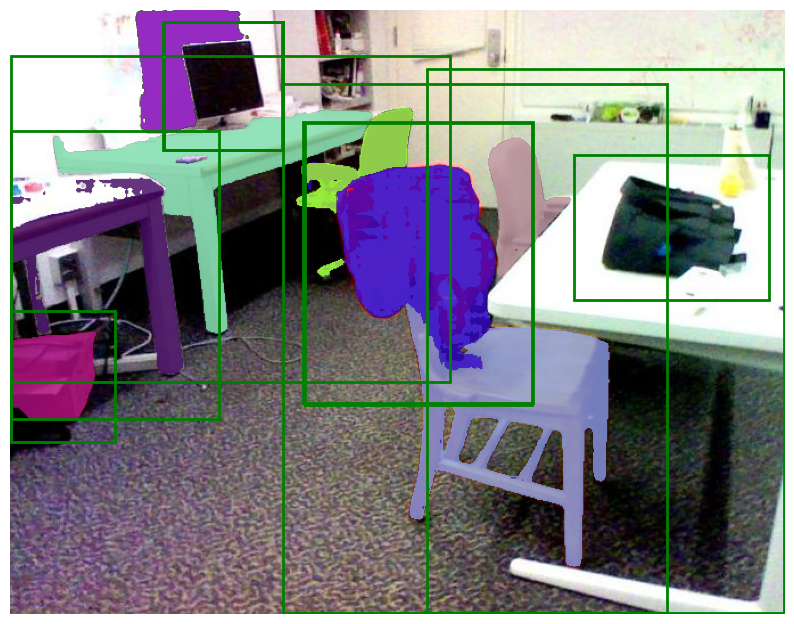

In [7]:
def show_mask(mask, ax, random_color=True):
    color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

image_cv = cv2.imread(color_path)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image_cv)
for i in range(len(masks)):
    if len(masks[i].shape) > 2:
        masks[i] = masks[i].squeeze(0)
    
    show_mask(masks[i], plt.gca(), random_color=True)
for box in boxes_xyxy:
    show_box(box.cpu().numpy(), plt.gca())
    print(box.cpu().numpy())
# for input_point in centers:
#     show_points(input_point, [1], plt.gca())

plt.axis('off')
plt.show()

In [8]:
# Set up paths
color_path = "/scratch/rhm4nj/cral/datasets/SUNRGBD/realsense/sh/2014_10_21-11_33_55-1311000041/image/0000075.jpg"
depth_path = "/scratch/rhm4nj/cral/datasets/SUNRGBD/realsense/sh/2014_10_21-11_33_55-1311000041/depth_bfx/0000075.png"
intrinsics_file = '/scratch/rhm4nj/cral/datasets/SUNRGBD/realsense/sh/2014_10_21-11_33_55-1311000041/intrinsics.txt'

ptclds = []

color_raw = o3d.io.read_image(color_path)
depth_raw_og = o3d.io.read_image(depth_path)

def load_intrinsics(filepath):
    # Read the 3x3 intrinsic matrix from file
    with open(filepath, 'r') as file:
        lines = file.readlines()

    intrinsic_matrix = np.array([list(map(float, line.split())) for line in lines])
    return intrinsic_matrix

width, height, _ = np.asarray(color_raw).shape

intrinsic_matrix = load_intrinsics(intrinsics_file)
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(
    width=width,
    height=height,
    fx=intrinsic_matrix[0, 0],
    fy=intrinsic_matrix[1, 1],
    cx=intrinsic_matrix[0, 2],
    cy=intrinsic_matrix[1, 2]
)

print(width, height)
print(masks.shape)
for mask in masks:
    mask_np = mask.squeeze(0).numpy() if isinstance(mask, torch.Tensor) else mask

    depth_raw_np = (np.asarray(depth_raw_og) / 10.0).astype(np.float32)  # Convert to meters and cast to float32
    # mask_np = np.ones_like(mask_np)
    depth_raw_np[~mask_np] = 0  # Zero-out values not covered by the mask
    depth_raw = o3d.geometry.Image(depth_raw_np)

    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color_raw, depth_raw, convert_rgb_to_intensity=False
    )

    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

    ptclds.append(pcd)


531 681
torch.Size([11, 1, 531, 681])


In [9]:
# # Assuming pcd is your Open3D point cloud
# import matplotlib.colors as mcolors

# plot = k3d.plot()

# for i, ptcld in enumerate(ptclds):
#     points = np.asarray(ptcld.points)

#     random_color = np.random.rand(3)
#     colors = np.asarray(ptcld.colors)
#     colors[:] = random_color  # Broadcasts the random color to all points
#     full_pcd.colors = o3d.utility.Vector3dVector(colors)

#     colors = (colors * 255).astype(np.uint8)  # Convert from float [0, 1] to int [0, 255]
#     colors = (colors[:, 0] << 16 | colors[:, 1] << 8 | colors[:, 2]).astype(np.uint32)  # RGB format

#     # Create a K3D plot
#     point_cloud = k3d.points(positions=points.astype(np.float32), 
#                             colors=colors, 
#                             point_size=0.01)
#     plot += point_cloud

#     np.save(f'outs/ptcld_{i}.npy', np.asarray(ptcld.points))

# plot.display()

NameError: name 'full_pcd' is not defined

In [12]:
def gen_points_dir(pcd_np, normals, radial_dist, delta, buffer=0):
    offset = delta + buffer
    out_ptcd = np.array([])
    while offset < radial_dist:
        if out_ptcd.any():
            out_ptcd = np.hstack([out_ptcd, pcd_np + offset * normals_normalized])
        else: 
            out_ptcd = pcd_np + offset * normals_normalized
            offset += delta
        
        return out_ptcd

plot = k3d.plot()
myptclds = ptclds[:-3]
for pcd in myptclds:
    pcd_np = np.asarray(pcd.points).astype(np.float32)

    # # normals
    # com = np.mean(pcd_np, axis=0)  # Center of mass (mean position of all points)
    # normals = pcd_np - com  # Vector from COM to each point
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30)
    )
    normals = np.asarray(pcd.normals).astype(np.float32)
    normals_normalized = normals / np.linalg.norm(normals, axis=1, keepdims=True)

    # envelope
    env_pcd_np = gen_points_dir(pcd_np, normals_normalized, radial_dist=0.2, delta=0.05, buffer=0.1)

    # domain
    k = 0.005
    domain_pcd_np = gen_points_dir(pcd_np, -normals_normalized, radial_dist=2 * k, delta=k)

    # display
    point_size = 0.01
    # plot = k3d.plot()
    plot += k3d.points(pcd_np, point_size=point_size, color=0x0000ff, name='interface points')  # Grey points
    # plot += k3d.points(env_pcd_np, point_size=point_size, color=0xABC4AA, name='envelope points')  # Grey points
    # plot += k3d.points(domain_pcd_np, point_size=point_size, color=0x00ff00, name='domain points')  # Grey points
    # plot += k3d.vectors(pcd_np, normals, color=0x444444, name='interface normals', line_width=0.0005, head_size=0.2)

plot.display()

Output()

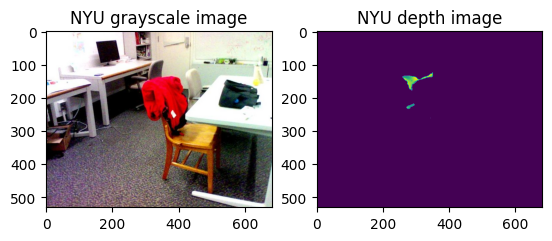

In [ ]:
plt.subplot(1, 2, 1)
plt.title('NYU grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('NYU depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [ ]:
print(color_raw)
print(depth_raw)
print(intrinsic_matrix)


Image of size 681x531, with 3 channels.
Use numpy.asarray to access buffer data.
Image of size 681x531, with 1 channels.
Use numpy.asarray to access buffer data.
[[691.584229   0.       362.777557]
 [  0.       691.584229 264.75    ]
 [  0.         0.         1.      ]]
